# Dementia Detection with MobileNet_v2

This notebook trains a machine learning system to detect dementia using the **MobileNet_v2** architecture. The training is based on images of spectrograms created in a separate notebook: `image_creator.ipynb`. 

## Data Source

The dataset used for training and testing is the **PROCESS-V1** dataset, which can be downloaded here:  
[Download PROCESS-V1 Dataset](https://syncandshare.lrz.de/getlink/fiSPLrnFVFo3DvWqXkLGdY/PROCESS-V1_test.zip)

- Only fully labeled data from the dataset is used for image grouping.

## Methodology

1. **Spectrogram Generation**:  
   Spectrograms are pre-generated in `image_creator.ipynb`.

2. **Training**:  
   - The MobileNet_v2 model is fine-tuned for dementia detection. 
   - The notebook includes versions for:
     - **2-class classification** (e.g., dementia vs. non-dementia).
     - **3-class classification** based on the original dataset labels.
   - Fast training is facilitated by using an NVIDIA graphics card with a **2000 Series or newer**.

3. **Results Verification**:  
   - Model interpretability is verified using **LIME (Local Interpretable Model-agnostic Explanations)**.
   - A **confusion matrix** is generated to evaluate classification performance.


In [1]:
!nvidia-smi
#!pip install imbalanced-learn
!pip install lime

Wed Dec 11 14:46:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050      WDDM  |   00000000:01:00.0  On |                  N/A |
| 40%   28C    P0             16W /  130W |    1220MiB /   8192MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
data_dir = r"F:\Peter\ML_exp\PROCESS-V1\Spectrograms"  # Replace with the path to the spectrograms
healthy_dir = os.path.join(data_dir, "Healthy")
not_healthy_dir = os.path.join(data_dir, "Not Healthy")

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


def cutmix(data, targets, alpha=1.0):
    """Apply CutMix augmentation on a batch of data and targets."""
    indices = torch.randperm(data.size(0))  # Shuffle batch indices
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    # Sample the lambda parameter from a Beta distribution
    lam = np.random.beta(alpha, alpha)
    H, W = data.size(2), data.size(3)

    # Compute the bounding box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly select the center of the bounding box
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Mix the images and adjust the labels
    data[:, :, bby1:bby2, bbx1:bbx2] = shuffled_data[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

    return data, targets, shuffled_targets, lam


# Prepare datasets and split into train/validation sets
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes  # ['Healthy', 'Not Healthy']

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define the model (using a pre-trained ResNet)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Updated weights usage
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 2 classes: Healthy and Not Healthy
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mixed precision training setup
scaler = GradScaler()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, average='binary'):
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed precision
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=20)

# Save the trained model
torch.save(model.state_dict(), "spectrogram_classifier_20.pth")


print("Model saved as spectrogram_classifier_20.pth")

In [2]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
data_dir = r"F:\Peter\ML_exp\PROCESS-V1\Spectrograms"  # Replace with the path to the spectrograms
healthy_dir = os.path.join(data_dir, "Healthy")
not_healthy_dir = os.path.join(data_dir, "Not Healthy")

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to optimize memory usage
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Prepare datasets and split into train/validation sets
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes  # ['Healthy', 'Not Healthy']

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define the model (using a pre-trained ResNet)
from torchvision.models import mobilenet_v2
model = mobilenet_v2(weights="IMAGENET1K_V1")
num_ftrs = model.last_channel
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Mixed precision training setup
scaler = GradScaler()

# Calculate metrics function
def calculate_metrics(y_true, y_pred, average='binary'):
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

import numpy as np

def cutmix(data, targets, alpha=1.0):
    """Apply CutMix augmentation on a batch of data and targets."""
    indices = torch.randperm(data.size(0))  # Shuffle batch indices
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    # Sample the lambda parameter from a Beta distribution
    lam = np.random.beta(alpha, alpha)
    H, W = data.size(2), data.size(3)

    # Compute the bounding box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly select the center of the bounding box
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Mix the images and adjust the labels
    data[:, :, bby1:bby2, bbx1:bbx2] = shuffled_data[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

    return data, targets, shuffled_targets, lam


# Training and Validation function
# Define the updated train_model function with advanced overfitting detection
def train_model_with_smote_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    best_val_f1 = 0.0
    lr = 0.0001
    alpha=1.0
    weight_decay = 1e-4
    overfitting_threshold = 3  # Number of consecutive epochs of overfitting to trigger adjustments
    overfitting_epochs = 0

    # Track historical loss differences for smarter overfitting detection
    loss_differences = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

        # --- Smarter Overfitting Detection ---
        loss_diff = val_loss - train_loss
        acc_diff = train_acc - val_acc
        loss_differences.append(loss_diff)

        # Check rolling average of loss differences
        if len(loss_differences) > 3:
            rolling_avg_loss_diff = np.mean(loss_differences[-3:])
            if rolling_avg_loss_diff > 0.1 and acc_diff > 0.1:
                overfitting_epochs += 1
                print(f"Overfitting detected (Rolling Loss Diff: {rolling_avg_loss_diff:.4f}).")
            else:
                overfitting_epochs = 0

        if overfitting_epochs >= overfitting_threshold:
            print("Overfitting persists. Adjusting learning rate and weight decay.")
            lr *= 0.5
            weight_decay *= 0.9
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                param_group['weight_decay'] = weight_decay
            overfitting_epochs = 0  # Reset counter

    # Explain model predictions with LIME after training
    explain_with_lime(model, val_loader, device)

# SMOTE: Handle imbalanced datasets
def apply_smote(train_loader):
    smote = SMOTE()
    train_data = []
    train_labels = []

    for inputs, labels in train_loader:
        train_data.extend(inputs.view(inputs.size(0), -1).numpy())
        train_labels.extend(labels.numpy())

    train_data_smote, train_labels_smote = smote.fit_resample(np.array(train_data), np.array(train_labels))
    print("SMOTE applied. Resampled dataset size:", len(train_labels_smote))

    return train_data_smote, train_labels_smote



# LIME: Explain predictions
def explain_with_lime(model, val_loader, device):
    explainer = LimeImageExplainer()

    model.eval()
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            sample_image = inputs[0].cpu().numpy().transpose(1, 2, 0)

            explanation = explainer.explain_instance(
                image=sample_image,
                classifier_fn=lambda x: model(torch.tensor(x.transpose(0, 3, 1, 2)).float().to(device)).detach().cpu().numpy(),
                top_labels=2,
                hide_color=0,
                num_samples=1000
            )

            temp, mask = explanation.get_image_and_mask(
                label=1,  # Assuming class 1 is "Not Healthy"
                positive_only=True,
                num_features=10,
                hide_rest=False
            )

            lime_image = mark_boundaries(temp, mask)
            plt.imshow(lime_image)
            plt.title("LIME Explanation")
            plt.show()
            break  # Explain one sample for demonstration

# Preprocess dataset with SMOTE
#train_data_smote, train_labels_smote = apply_smote(train_loader)

# Train model with the new improvements
#train_model_with_smote_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=15)



# Train the model
#train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=15)

# Save the final trained model
#torch.save(model.state_dict(), "final_spectrogram_classifier_15.pth")
print("Model saved as final_spectrogram_classifier_15.pth")


Using device: cuda
Model saved as final_spectrogram_classifier_15.pth


**Now with 3 classes (based on dataset)**


In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to display confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Training and validation function with confusion matrix
def train_model_with_confusion_matrix(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    best_val_f1 = 0.0
    lr = 0.0001
    alpha = 1.0
    weight_decay = 1e-4

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    # Plot confusion matrix for validation results
    print("\nConfusion Matrix:")
    plot_confusion_matrix(all_labels, all_preds, class_names)



In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot training and validation loss and accuracy
def plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Function to display confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Training and validation function with metric tracking and visualization
def train_model_with_plots_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    best_val_f1 = 0.0
    lr = 0.0001
    alpha = 1.0
    weight_decay = 1e-4

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

        # Plot confusion matrix for validation results
        if epoch == epochs - 1:  # Plot confusion matrix only after the last epoch
            print("\nConfusion Matrix:")
            plot_confusion_matrix(all_labels, all_preds, class_names)

    # Plot training progress
    plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies)

    # Explain model predictions with LIME
    explain_with_lime(model, val_loader, device)



Using device: cuda
Detected classes: ['Dementia', 'HC', 'MCI'], Number of classes: 3

Epoch 1/15, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9691, Train Acc: 0.5054
Val Loss: 0.8870, Val Acc: 0.5456
Val F1 Score: 0.5103, Precision: 0.5066, Recall: 0.5456
Best model saved!

Epoch 2/15, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9281, Train Acc: 0.5340
Val Loss: 0.8387, Val Acc: 0.6153
Val F1 Score: 0.5841, Precision: 0.5589, Recall: 0.6153
Best model saved!

Epoch 3/15, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.8987, Train Acc: 0.5701
Val Loss: 0.7783, Val Acc: 0.6378
Val F1 Score: 0.6274, Precision: 0.6312, Recall: 0.6378
Best model saved!

Epoch 4/15, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.8512, Train Acc: 0.6024
Val Loss: 0.7249, Val Acc: 0.6907
Val F1 Score: 0.6796, Precision: 0.6935, Recall: 0.6907
Best model saved!

Epoch 5/15, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.8288, Train 

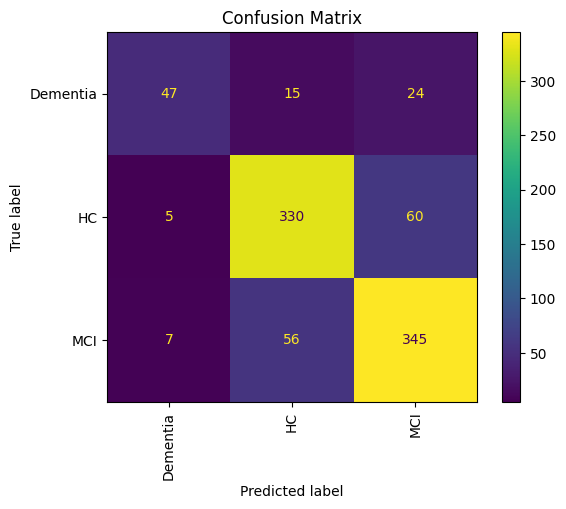

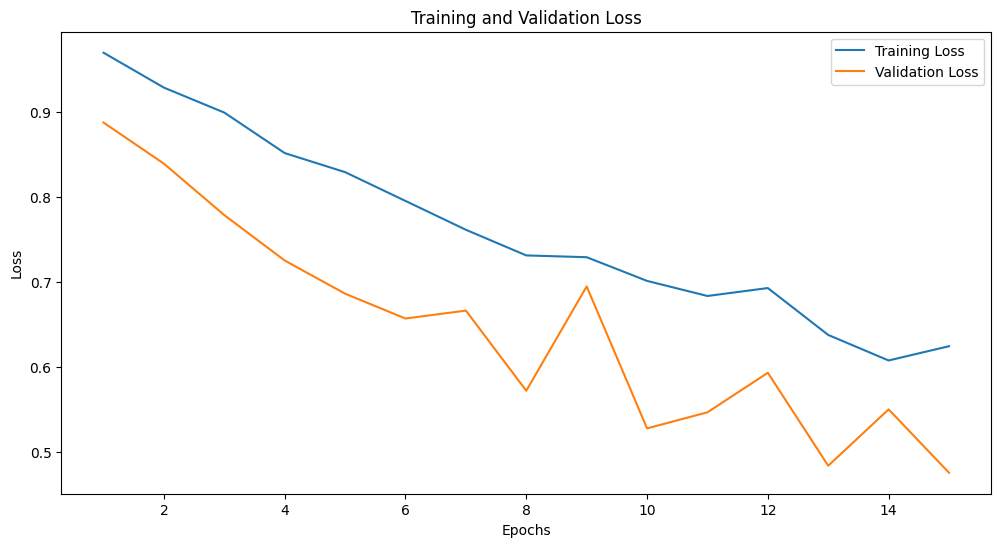

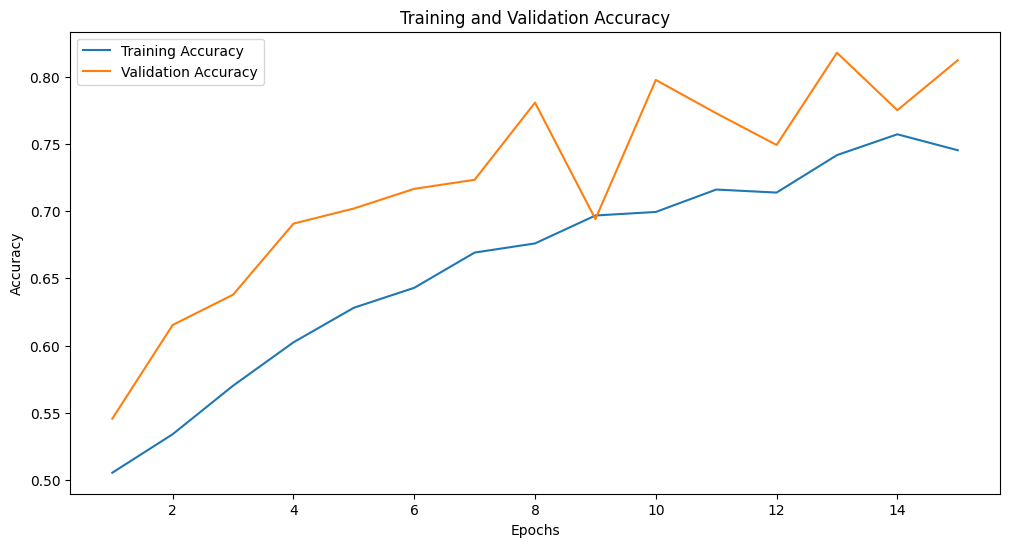

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


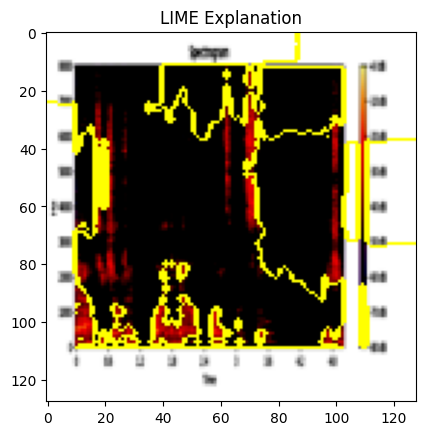

Model saved as final_spectrogram_classifier_dynamic.pth


In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.cuda.amp import GradScaler, autocast
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
data_dir = r"F:\Peter\ML_exp\PROCESS-V1\Spectrograms_3"  # Replace with the path to the spectrograms

# Dynamically get the list of classes based on subfolders
class_names = sorted(next(os.walk(data_dir))[1])  # List of folder names
num_classes = len(class_names)
print(f"Detected classes: {class_names}, Number of classes: {num_classes}")

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to optimize memory usage
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Prepare datasets and split into train/validation sets
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define the model (using a pre-trained MobileNetV2)
from torchvision.models import mobilenet_v2
model = mobilenet_v2(weights="IMAGENET1K_V1")
num_ftrs = model.last_channel

# Modify the final layer to match the number of classes
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Mixed precision training setup
scaler = GradScaler()

# Calculate metrics function
def calculate_metrics(y_true, y_pred, average='weighted'):
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    precision = precision_score(y_true, y_pred, average=average, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average, zero_division=0)
    return f1, precision, recall

# SMOTE and other training functions remain unchanged...

# Train the model with the new functionality
train_model_with_plots_and_explainability(
    model, criterion, optimizer, train_loader, val_loader, device, epochs=15
)
# Train the model with confusion matrix functionality / updated 
#train_model_with_confusion_matrix(
#    model, criterion, optimizer, train_loader, val_loader, device, epochs=20
#)

# Save the final trained model
torch.save(model.state_dict(), "final_spectrogram_classifier_dynamic.pth")
print("Model saved as final_spectrogram_classifier_dynamic.pth")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

# Example model architecture (replace with your own)
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Dummy forward pass
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

def objective(trial):
    """
    Objective function for Optuna hyperparameter search.
    Returns: validation F1 score
    """

    # --- Suggest hyperparameters ---
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    alpha = trial.suggest_float("alpha", 0.2, 1.0)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    epochs = 5  # Keep this short for quick trials; you can adjust as needed.

    # --- Build your model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyModel(num_classes=len(class_names)).to(device)

    # Define loss, optimizer, etc.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = GradScaler()

    # --- Tracking metrics ---
    best_val_f1 = 0.0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix (assumed you have this function defined)
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad(set_to_none=True)

            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Compute training loss & accuracy
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (
                lam * predicted.eq(targets_a).sum().item()
                + (1 - lam) * predicted.eq(targets_b).sum().item()
            )

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Calculate metrics (assumed you have this function)
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        # Save the best model based on validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1

    # Return the best validation F1 of this trial
    return best_val_f1
